# Comparing Two Strategies

Strategy one: Pure random walk
    
Strategy two: Chemotactic random walk

The file includes:
 - Model specification
 - Visualizing the trajectories for 3 cells using each strategy
 - Quantitative comparison of the performance

## Part 1 Model Specification
Please refer to the jupyter notebook of each strategy for detailed walk through of the models.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import colors
from matplotlib import patches
import colorspace

SEED = 1024  #Any random seed
np.random.seed(SEED)

#Constants for E.coli tumbling
tumble_time_mu = 0.1

#E.coli movement constants
speed = 20         #um/s, speed of E.coli movement
response_time = 0.5 #Able to respond every 0.5 second

#Model constants
start = [0, 0]  #All cells start at [0, 0]
ligand_center = [1500, 1500] #Position of highest concentration
center_exponent, start_exponent = 8, 2
origin_to_center = 0 #Distance from start to center, intialized here, will be actually calculated later
saturation_conc = 10 ** 8 #From BNG model

# Calculates Euclidean distance between point a and b
def euclidean_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Exponential gradient, the exponent follows a linear relationship with distance to center
def calc_concentration(pos):
    dist = euclidean_distance(pos, ligand_center)
    exponent = (1 - dist / origin_to_center) * (center_exponent - start_exponent) + start_exponent
    
    return 10 ** exponent

# Samples the new direction and time of a tumble
# Calculates projection on the Horizontal and Vertical direction for the next move
# No input
# Return the horizontal movement projection (float), the vertical one (float), tumble time (float)
def tumble_move():
    #Sample the new direction unformly from 0 to 2pi, record as a float
    new_dir = np.random.uniform(low = 0.0, high = 2 * math.pi)
        
    projection_h = math.cos(new_dir) #displacement projected on Horizontal direction for next run, float
    projection_v = math.sin(new_dir) #displacement projected on Vertical direction for next run, float
    
    #Length of the tumbling sampled from exponential distribution with mean=0.1, float
    tumble_time = np.random.exponential(tumble_time_mu)
    
    return projection_h, projection_v, tumble_time

### Simulation method for pure random

In [16]:
def simulate_std_random(num_cells, duration, run_time_expected):
    
    #Takes the shape (num_cells, duration+1, 2)
    #any point [x,y] on the simulated trajectories can be accessed via paths[cell, time]
    paths = np.zeros((num_cells, duration + 1, 2))

    for rep in range(num_cells):
        # Initialize simulation
        t = 0 #record the time elapse
        curr_position = np.array(start) #start at [0, 0]
        projection_h, projection_v, tumble_time = tumble_move() #Initialize direction randomly
        past_sec = 0

        while t < duration:
            
            #run
            curr_run_time = np.random.exponential(run_time_expected) #get run duration, float
            #displacement on either direction is calculated as the projection * speed * time
            #update current position by summing old position and displacement
            curr_position = curr_position + np.array([projection_h, projection_v]) * speed * curr_run_time
            
            #tumble
            projection_h, projection_v, tumble_time = tumble_move()
            
            #increment time
            t += (curr_run_time + tumble_time)

            #record position approximate for integer number of second
            curr_sec = int(t)
            for sec in range(past_sec, min(curr_sec, duration) + 1):
                #fill values from last time point to current time point
                paths[rep, sec] = curr_position.copy()
                past_sec= curr_sec
    
    return paths

### Simulation method for Chemotactic random walk

#### Function to calculate run duration
The run duration follows an exponential distribution with `exp_run_time`.

When no gradient is present, `exp_run_time` = `time_exp`. When there is a change in ligand concentration, `exp_run_time` changes accordingly. The change is calculated as `(curr_conc - past_conc) / past_conc` to normalize for the exponential gradient. We model this response with `exp_run_time` = `time_exp` + 10 * `change`.

In [ ]:
# Calculate the wait time for next tumbling event
# Input: current concentration (float), past concentration (float), position (array [x, y]), expected run time (float)
# Return: duration of current run (float)
def run_duration(curr_conc, past_conc, position, run_time_expected):
        
    curr_conc = min(curr_conc, saturation_conc) #Can't detect higher concentration if receptors saturates
    past_conc = min(past_conc, saturation_conc)
    change = (curr_conc - past_conc) / past_conc #proportion change in concentration, float
    run_time_expected_adj_conc = run_time_expected * (1 + 10 * change) #adjust based on concentration change, float
    
    if run_time_expected_adj_conc < 0.000001:
        run_time_expected_adj_conc = 0.000001 #positive wait times
    elif run_time_expected_adj_conc > 4 * run_time_expected:
        run_time_expected_adj_conc = 4 * run_time_expected     #the decrease to tumbling frequency is only to a certain extent
    #Sample the duration of current run from exponential distribution, mean=run_time_expected_adj_conc
    curr_run_time = np.random.exponential(run_time_expected_adj_conc)
    
    return curr_run_time

#### Function for simulation

It handles simulation through time for all `run_time_expected` of all cells.

For each cell, simulate through time as the following:

while `t` < duration:
- Assess the current concentration
- Update current run duration `curr_run_time` and whether it is up/down gradient
- If `curr_run_time` < 0.5s:
    - run for `curr_run_time` second along current direction
    - Sample the duration of tumble `tumble_time` and the resulted direction
    - increment t by `curr_run_time` and `tumble_time`
- If `curr_run_time` > 0.5s:
    - run for 0.5s along current direction
    - increment `t` by 0.5s (and then the cell will re-assess the new concentration, and decide the duration of next run)

In [27]:
# This function performs simulation
# Input: number of cells to simulate (int), how many seconds (int), the expected run time before tumble (float)
# Return: the simulated trajectories paths: array of shape (num_cells, duration+1, 2)
def simulate_chemotaxis(num_cells, duration, run_time_expected):
    
    #Takes the shape (num_cells, duration+1, 2)
    #any point [x,y] on the simulated trajectories can be accessed via paths[cell, time]
    paths = np.zeros((num_cells, duration + 1, 2))

    for rep in range(num_cells):
        # Initialize simulation
        t = 0 #record the time elapse
        curr_position = np.array(start) #start at [0, 0]
        past_conc = calc_concentration(start) #Initialize concentration
        projection_h, projection_v, tumble_time = tumble_move() #Initialize direction randomly

        while t < duration:
            curr_conc = calc_concentration(curr_position)

            curr_run_time = run_duration(curr_conc, past_conc, curr_position, run_time_expected) #get run duration, float

            # if run time (r) is within the step (s), run for r second and then tumble
            if curr_run_time < response_time: 
                #displacement on either direction is calculated as the projection * speed * time
                #update current position by summing old position and displacement
                curr_position = curr_position + np.array([projection_h, projection_v]) * speed * curr_run_time
                projection_h, projection_v, tumble_time = tumble_move() #tumble
                t += (curr_run_time + tumble_time) #increment time

            # if r > s, run for r; then it will be in the next iteration
            else:
                #displacement on either direction is calculated as the projection * speed * time
                #update current position by summing old position and displacement
                curr_position = curr_position + np.array([projection_h, projection_v]) * speed * response_time
                t += response_time #no tumble here

            #record position approximate for integer number of second
            curr_sec = int(t)
            if curr_sec <= duration:
                #fill values from last time point to current time point
                paths[rep, curr_sec] = curr_position.copy()
                past_conc = curr_conc
    
    return paths

## Part 2: Visualizing trajectories
Run simulation for 3 cells for each strategy, plot paths

In [38]:
#Run simulation for 3 cells for each strategy, plot paths
duration = 800   #seconds, duration of the simulation
num_cells = 3
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
run_time_expected = 1.0

paths_rand = simulate_std_random(num_cells, duration, run_time_expected)
paths_che = simulate_chemotaxis(num_cells, duration, run_time_expected)
paths = np.array([paths_rand, paths_che])

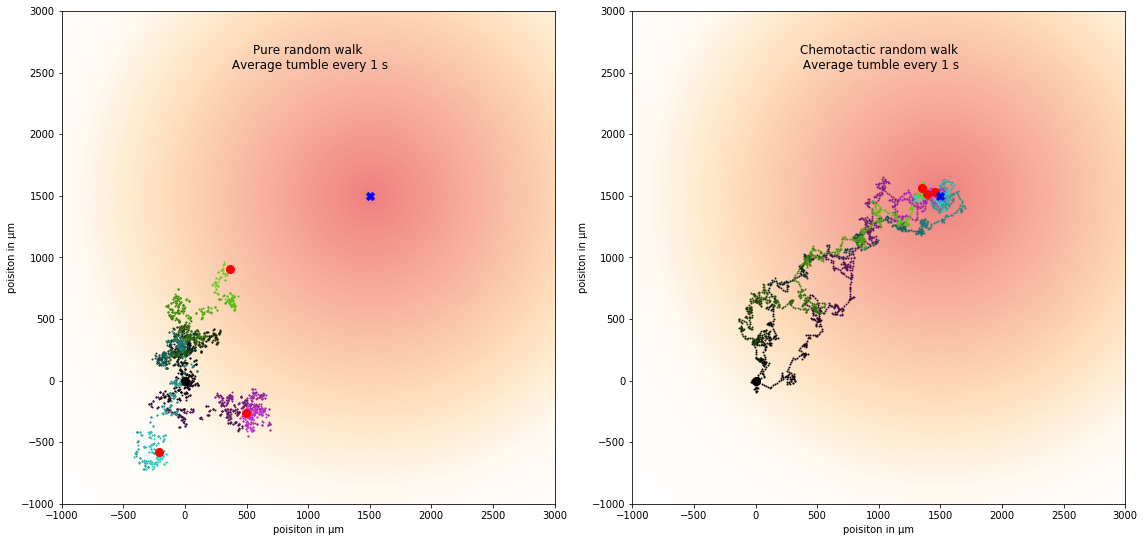

In [39]:
#Below are all for plotting purposes
methods = ["Pure random walk", "Chemotactic random walk"]
fig, ax = plt.subplots(1, 2, figsize = (16, 8)) #1*2 subplots, size 16*8

#First set color map
mycolor = [[256, 256, 256], [256, 255, 254], [256, 253, 250], [256, 250, 240], [255, 236, 209], [255, 218, 185], [251, 196, 171], [248, 173, 157], [244, 151, 142], [240, 128, 128]] #from coolors：）
for i in mycolor:
    for j in range(len(i)):
        i[j] *= (1/256)
cmap_color = colors.LinearSegmentedColormap.from_list('my_list', mycolor) #Linearly segment these colors to create a continuous color map

#Store the concentrations for each integer position in a matrix
conc_matrix = np.zeros((4000, 4000)) #we will display from [-1000, -1000] to [3000, 3000]
for i in range(4000):
    for j in range(4000):
        conc_matrix[i][j] = math.log(calc_concentration([i - 1000, j - 1000]))

#Repeat for the two strategies
for m in range(2):
    #Simulate the gradient distribution, plot as a heatmap
    ax[m].imshow(conc_matrix.T, cmap=cmap_color, interpolation='nearest', extent = [-1000, 3000, -1000, 3000], origin = 'lower')

    #Plot simulation results
    time_frac = 1.0 / duration
    #Plot the trajectories. Time progress: dark -> colorful
    for t in range(duration):
        ax[m].plot(paths[m,0,t,0], paths[m,0,t,1], 'o', markersize = 1, color = (0.2 * time_frac * t, 0.85 * time_frac * t, 0.8 * time_frac * t))
        ax[m].plot(paths[m,1,t,0], paths[m,1,t,1], 'o', markersize = 1, color = (0.85 * time_frac * t, 0.2 * time_frac * t, 0.9 * time_frac * t))
        ax[m].plot(paths[m,2,t,0], paths[m,2,t,1], 'o', markersize = 1, color = (0.4 * time_frac * t, 0.85 * time_frac * t, 0.1 * time_frac * t))
    ax[m].plot(start[0], start[1], 'ko', markersize = 8) #Mark the starting point [0, 0]
    for i in range(num_cells):
        ax[m].plot(paths[m,i,-1,0], paths[m,i,-1,1], 'ro', markersize = 8) #Mark the terminal points for each cell
    ax[m].plot(1500, 1500, 'bX', markersize = 8) #Mark the highest concentration point [1500, 1500]

    ax[m].set_title("{}\n Average tumble every 1 s".format(methods[m]), x = 0.5, y = 0.87)
    ax[m].set_xlim(-1000, 3000)
    ax[m].set_ylim(-1000, 3000)
    ax[m].set_xlabel("poisiton in μm")
    ax[m].set_ylabel("poisiton in μm")

fig.tight_layout()

plt.show()

## Part 3: Quantitative comparison
Run simulation for 500 cells for each strategy, plot average distance to the goal

In [40]:
#Run simulation for 3 cells with different background tumbling frequencies, Plot paths

duration = 1500   #seconds, duration of the simulation
num_cells = 500
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
run_time_expected = 1.0

paths_rand = simulate_std_random(num_cells, duration, run_time_expected)
paths_che = simulate_chemotaxis(num_cells, duration, run_time_expected)
paths = np.array([paths_rand, paths_che])

all_distance = np.zeros((2, num_cells, duration)) #Initialize to store results: methods, number, duration

for m in range(2): #two methods
    for c in range(num_cells): #each cell
        for t in range(duration): #every time point
            pos = paths[m, c, t]
            dist = euclidean_distance(ligand_center, pos)
            all_distance[m, c, t] = dist

all_dist_avg = np.mean(all_distance, axis = 1) #Calculate average over cells, array of shape (2,duration,)
all_dist_std = np.std(all_distance, axis = 1) #Calculate the standard deviation, array of shape (2,duration,)

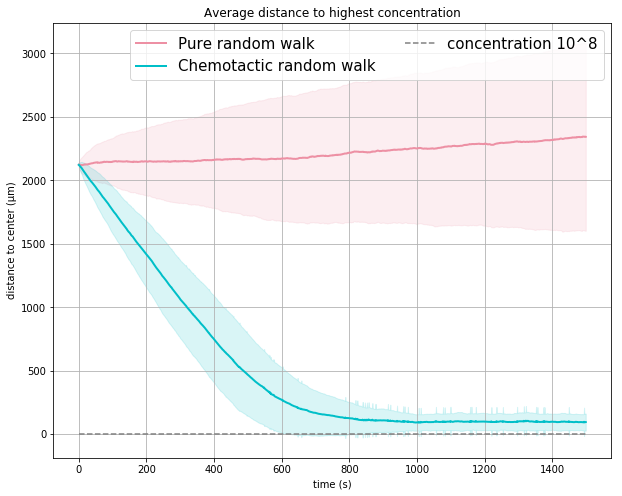

In [41]:
#Below are all for plotting purposes
#Define the colors to use
colors1 = colorspace.qualitative_hcl(h=[0, 200.], c = 60, l = 70, pallete = "dynamic")(2)

xs = np.arange(0, duration) #Set the x-axis for plot: time points. Array of integers of shape (duration,)

fig, ax = plt.subplots(1, figsize = (10, 8)) #Initialize the plot with 1*1 subplot of size 10*8

for m in range(2):
    #Get the result for this strategy
    mu, sig = all_dist_avg[m], all_dist_std[m]
    #Plot average distance vs. time
    ax.plot(xs, mu, lw=2, label="{}".format(methods[m]), color=colors1[m])
    #Fill in average +/- one standard deviation vs. time
    ax.fill_between(xs, mu + sig, mu - sig, color = colors1[m], alpha=0.15)

ax.set_title("Average distance to highest concentration")
ax.set_xlabel('time (s)')
ax.set_ylabel('distance to center (µm)')
ax.hlines(0, 0, duration, colors='gray', linestyles='dashed', label='concentration 10^8')
ax.legend(loc='upper right', ncol = 2, fontsize = 15)

ax.grid()